In [3]:
import numpy as np
import os
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
from tqdm.notebook import tqdm
from copy import deepcopy
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

In [4]:
# Rock Paper Scissors actions
action_to_descr = 'RPS'
n_act = len(action_to_descr)

In [5]:
def rewards(a1, a2):
    """Rock paper scissors game."""
    a1 = action_to_descr[a1]
    a2 = action_to_descr[a2]
    if a1 == a2:
        return (0, 0)
    outcomes = {'RP': (-1, 1),
     'RS': (1, -1),
     'PS': (-1, 1),
     
    }
    a1a2 = a1 + a2
    a2a1 = a1a2[::-1]
    if a1a2 in outcomes:
        return outcomes[a1a2]
    elif a2a1 in outcomes:
        return outcomes[a2a1][::-1]
    else:
        raise Exception("Unkown action pair %s" % a1a2)

## All outcomes (sanity check)

In [6]:
for a1 in range(n_act):
    for a2 in range(n_act):
        r = rewards(a1, a2)
        ad1 = action_to_descr[a1]
        ad2 = action_to_descr[a2]
        descr = ""
        if r[0] > r[1]:
            descr = "%s wins" % ad1
        elif r[1] > r[0]:
            descr = "%s loses" % ad1
        else:
            descr = "tie"
        print("%s vs %s => %s" % (ad1, ad2, descr))

R vs R => tie
R vs P => R loses
R vs S => R wins
P vs R => P wins
P vs P => tie
P vs S => P loses
S vs R => S loses
S vs P => S wins
S vs S => tie


## Agent and environment

In [7]:
class Trainer(object):
    def __init__(self, agent):
        self.agent = agent
        self.optimizer = tf.keras.optimizers.Adam(1e-2)
        
    def train(self, return_loss=False):
        loss = 0
        if not self.agent.train_data:
            return

        #@tf.function 
        def get_reinforce_loss(data, model):
            loss = 0.0
            for (xi, a, r, opponent) in data:
                loss -= r * tf.math.log(model(np.array([xi]))[0][a])
            loss /= len(data)
            return loss

        if return_loss:
            return get_reinforce_loss(self.agent.train_data, self.agent.model)
        
        with tf.GradientTape() as tape:
            loss = get_reinforce_loss(self.agent.train_data, self.agent.model)      

        grads = tape.gradient(loss, self.agent.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.agent.model.trainable_variables))
        self.agent.train_data = []
        
class RPCAgent(object):
    """Rock Paper Scissors agent."""
    def __init__(self, noise_dim, identity=None, train_every=10):
        self.noise_dim = noise_dim
        self.identity = identity
        self.model = tf.keras.Sequential([
            tf.keras.layers.Dense(10, input_shape=(self.noise_dim,), activation='linear'),
            tf.keras.layers.Dense(n_act, activation=None),
          tf.keras.layers.Softmax(),
        ])
        self.trainer = Trainer(agent=self)
        self.do_train = True
        
        self.data = []
        self.train_data = []
        
        self.reward_by_opponent = {}
        self.train_every = train_every
        
    def step(self, xi):
        p = self.model(np.array([xi]))[0].numpy()
        p = p / np.sum(p)
        return np.random.choice(range(n_act), p=p)

    def register_episode(self, h, opponent=None):
        self.data.append(deepcopy(list(h)) + [opponent])
        self.train_data.append(self.data[-1])
        if opponent not in self.reward_by_opponent:
            self.reward_by_opponent[opponent] = []
        self.reward_by_opponent[opponent].append(h[-1])
        self._train()
        
    def _train(self):
        if not self.do_train:
            return
        if len(self.data) % self.train_every == 0:
            self.trainer.train()
    
    def __repr__(self):
        opponents = np.unique([x[-1].identity for x in self.data])
        return "<Agent id=%d wisdom=%d opponents=%d>" % (self.identity, len(self.data),
                                            len(opponents))

class RPCEnv(object):
    """Rock paper scissors environment."""
    def __init__(self, noise_dim=10):
        self.noise_dim = noise_dim
    def reset(self):
        pass
    def step(self, a1, a2):
        R = rewards(a1, a2)
        assert np.sum(R) == 0
        return R
    def reset(self):
        return np.random.randn(self.noise_dim)
    def __repr__(self):
        return "<Env noise_dim=%d>" % self.noise_dim
    
class Universe(object):
    """Interaction between 2 agents in the environment."""
    def __init__(self, environment, agents, monitor, invert_reward_2=False):
        self.environment = environment
        self.monitor = monitor
        self.agents = agents
        self.invert_reward_2 = invert_reward_2
        assert len(self.agents) == 2
        
    def episode(self):
        xi = self.environment.reset()
        a1 = self.agents[0].step(xi)
        a2 = self.agents[1].step(xi)
        rews = self.environment.step(a1, a2)
        
        if self.invert_reward_2:
            rews = [rews[0], rews[0]]
        
        episode = (xi, a1, a2, rews)
        self.agents[0].register_episode((xi, a1, rews[0]), opponent=self.agents[1])
        self.agents[1].register_episode((xi, a2, rews[1]), opponent=self.agents[0])
        self.monitor.register(A1=self.agents[0],
                              A2=self.agents[1],
                              episode=episode)
        return rews
    
    def __repr__(self):
        return "<Universe\n  Environment=%s\n  Agents=%s\n>" % (self.environment, self.agents)
    
class Monitor(object):
    """Tracks agent's performance."""
    def __init__(self, agents):
        self.agents = agents
        self.data = []
        
    def register(self, A1, A2, episode):
        assert A1 in self.agents
        assert A2 in self.agents
        self.data.append([A1, A2, deepcopy(episode)])
        
    def stats(self):
        action_stats = {A: [0 for _ in range(n_act)] for A in self.agents}
        reward_stats = {A: {x: 0 for x in [-1, 0, 1]} for A in self.agents}

        for (A1, A2, (xi, a1, a2, (r1, r2))) in m.data:
            action_stats[A1][a1] += 1
            action_stats[A2][a2] += 1
            reward_stats[A1][r1] += 1
            reward_stats[A2][r2] += 1
            
        return {'reward': reward_stats,
                'action': action_stats}
        
    def __repr__(self):
        return "<Monitor games=%d>" % len(self.data)

## Initial training phase

In [8]:
# environment
env = RPCEnv(noise_dim=4)

# how many agents to create?
N_AGENTS = 10

# how many games to play during test?
N_GAMES = 1000

# creating agents
AGENTS = [RPCAgent(noise_dim=env.noise_dim, identity=i) for i in range(N_AGENTS)]

# to track the performance
m = Monitor(agents=AGENTS)

In [9]:
def sample_agent():
    """Get one of the agents."""
    return np.random.choice(AGENTS)

In [30]:
# Running training games
for _ in tqdm(range(N_GAMES)):
    A1, A2 = sample_agent(), sample_agent()
    A1.do_train = True
    A2.do_train = True
    U = Universe(environment=env, agents=[A1, A2], monitor=m)
    rew = U.episode()
    del U

In [31]:
AGENTS

[<Agent id=0 wisdom=189 opponents=10>,
 <Agent id=1 wisdom=212 opponents=10>,
 <Agent id=2 wisdom=200 opponents=10>,
 <Agent id=3 wisdom=196 opponents=10>,
 <Agent id=4 wisdom=209 opponents=10>,
 <Agent id=5 wisdom=205 opponents=10>,
 <Agent id=6 wisdom=218 opponents=10>,
 <Agent id=7 wisdom=176 opponents=10>,
 <Agent id=8 wisdom=181 opponents=10>,
 <Agent id=9 wisdom=214 opponents=10>]

## Train stats

In [32]:
m.stats()

{'reward': {<Agent id=0 wisdom=189 opponents=10>: {-1: 57, 0: 67, 1: 65},
  <Agent id=1 wisdom=212 opponents=10>: {-1: 59, 0: 84, 1: 69},
  <Agent id=2 wisdom=200 opponents=10>: {-1: 57, 0: 71, 1: 72},
  <Agent id=3 wisdom=196 opponents=10>: {-1: 64, 0: 75, 1: 57},
  <Agent id=4 wisdom=209 opponents=10>: {-1: 59, 0: 80, 1: 70},
  <Agent id=5 wisdom=205 opponents=10>: {-1: 74, 0: 72, 1: 59},
  <Agent id=6 wisdom=218 opponents=10>: {-1: 73, 0: 76, 1: 69},
  <Agent id=7 wisdom=176 opponents=10>: {-1: 65, 0: 57, 1: 54},
  <Agent id=8 wisdom=181 opponents=10>: {-1: 62, 0: 86, 1: 33},
  <Agent id=9 wisdom=214 opponents=10>: {-1: 55, 0: 82, 1: 77}},
 'action': {<Agent id=0 wisdom=189 opponents=10>: [57, 60, 72],
  <Agent id=1 wisdom=212 opponents=10>: [70, 82, 60],
  <Agent id=2 wisdom=200 opponents=10>: [66, 69, 65],
  <Agent id=3 wisdom=196 opponents=10>: [75, 48, 73],
  <Agent id=4 wisdom=209 opponents=10>: [74, 69, 66],
  <Agent id=5 wisdom=205 opponents=10>: [69, 64, 72],
  <Agent id=6 w

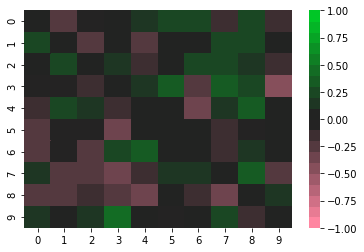

In [33]:
matrix = np.zeros((len(AGENTS), len(AGENTS)))
for i1, A1 in enumerate(AGENTS):
    for i2, A2 in enumerate(AGENTS):
        matrix[i1, i2] = np.mean(A1.reward_by_opponent[A2])
cm = sns.diverging_palette(0, 129, l=70, s=100, n=20, center="dark")
sns.heatmap(matrix, vmin=-1, vmax=1, cmap=cm)

## Running without training

In [34]:
# our agent
A = AGENTS[0]

# number of games to test for each agent
N_TEST_GAMES = 10

# to track the performance
m_test = Monitor(agents=AGENTS)

# Running training games
for _ in tqdm(range(N_TEST_GAMES)):
    for A2 in AGENTS[1:]:
        A.do_train = False
        A2.do_train = False
        U = Universe(environment=env, agents=[A, A2], monitor=m_test)
        rew = U.episode()
        del U

In [35]:
results = {x: y[AGENTS[0]] for x, y in m_test.stats().items()}

In [36]:
results['action']

[57, 60, 72]

In [37]:
rew = results['reward']

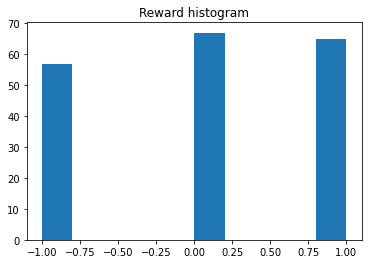

In [38]:
plt.title("Reward histogram")
plt.hist([x for x, y in rew.items() for _ in range(y)])
plt.show()

# Playing with an UNKNOWN opponent

In [39]:
A1 = AGENTS[0]
A2 = np.random.choice(AGENTS[1:])
true_opponent = AGENTS.index(A2)
true_opponent

6

In [40]:
A1.do_train = False
A2.do_train = False

## Identifying threat

In [41]:
# to track the performance
m_estimate = Monitor(agents=AGENTS)

U = Universe(environment=env, agents=[A1, A2], monitor=m_estimate)
for _ in tqdm(range(50)):
    rew = U.episode()

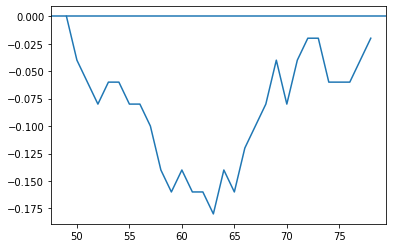

In [42]:
plt.plot(pd.Series(A1.reward_by_opponent[A2]).rolling(50).mean())
plt.axhline(0)

In [43]:
def dict_argmax(d):
    keys = list(d.keys())
    vals = [d[k] for k in keys]
    idx = np.argmax(vals)
    return keys[idx]

agent_logprobs = {A: 0 for A in AGENTS}
for (_, _, (xi, a1, a2, (r1, r2))) in m_estimate.data:
    for A in AGENTS:
        agent_logprobs[A] += np.log(A.model(np.array([xi]))[0][a2].numpy())
estimated_agent = dict_argmax(agent_logprobs)

In [44]:
print("Estimated id %d True id %d" % (estimated_agent.identity, A2.identity))

Estimated id 6 True id 6


### Adversarial training

In [45]:
A1.do_train = True
estimated_agent.do_train = False

In [46]:
U = Universe(environment=env, agents=[A1, estimated_agent], monitor=m_estimate)
for _ in tqdm(range(1000)):
    rew = U.episode()

### Testing time! 

In [47]:
# to track the performance
m_estimate = Monitor(agents=AGENTS)

U = Universe(environment=env, agents=[A1, A2], monitor=m_estimate)
for _ in tqdm(range(50)):
    rew = U.episode()

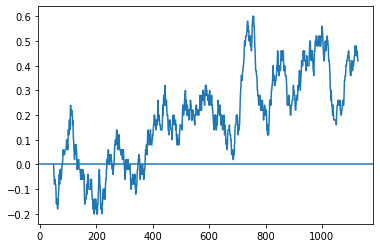

In [48]:
plt.plot(pd.Series(A1.reward_by_opponent[A2]).rolling(50).mean())
plt.axhline(0)

# Threat estimation with training adversarial agent-models
1. There is an unknown opponent
2. We play with it a bit
3. Then, we train an opponent model which would have done same actions
4. We train ourselves against this model
5. We try ourselves against the original unknown opponent

In [10]:
A1 = RPCAgent(noise_dim=env.noise_dim, identity=-2)
A2 = np.random.choice(AGENTS[1:])
true_opponent = AGENTS.index(A2)
true_opponent

2

In [11]:
A1.do_train = False
A2.do_train = False

In [12]:
# to track the performance
m_estimate = Monitor(agents=AGENTS + [A1])

U = Universe(environment=env, agents=[A1, A2], monitor=m_estimate)
for _ in tqdm(range(50)):
    rew = U.episode()

In [13]:
# creating a model of the aversary (so far, it is random)
adversary_agent_model = RPCAgent(noise_dim=env.noise_dim, identity=-1)

In [18]:
# collecting initial data
xis = []
acts = []

for (_, _, (xi, a1, a2, (r1, r2))) in m_estimate.data:
    xis.append(xi)
    acts.append(a2)

In [19]:
xis = np.array(xis)
acts = np.array(acts)

In [20]:
def fit_rl_agent_on_supervised_data(agent, xis, acts, epochs=10, do_plot=False):
    """Fit the policy on given data in a supervised way."""
    optimizer = tf.keras.optimizers.Adam(1e-2)
    loss_fcn = tf.keras.losses.SparseCategoricalCrossentropy()

    def epoch():
        """One supervised epoch."""
        
        # not working if optimizing with 2 optimizers
        
        with tf.GradientTape() as tape:
            ys = agent.model(xis)
            loss_superv = loss_fcn(acts, ys)
            loss_rl = agent.trainer.train(return_loss=True)
            if loss_rl is None:
                loss_rl = tf.Variable(0.0)
            loss_rl *= 0# 30
            #print(loss_superv, loss_rl)
            loss = loss_superv + loss_rl
        grads = tape.gradient(loss, agent.model.trainable_variables)
        optimizer.apply_gradients(zip(grads, agent.model.trainable_variables))
        
        return loss_superv.numpy(), loss_rl.numpy(), loss.numpy()

    losses = [epoch() for _ in range(epochs)]
    

    if do_plot:
        losses = np.array(losses)
        plt.title("Supervised loss")
        plt.plot(losses[:, 0], label="supervised")
        plt.plot(losses[:, 1], label="rl")
        plt.plot(losses[:, 2], label="total")
        plt.legend()
        plt.xlabel("Epoch")
    
    return losses

Try annealing mixing coefficient. 

Or adding a constant "maximal distance to the data", and run supervised separate optimizer until reaching it.

## Bootstrapping adversary from existing data

In [21]:
supervised_losses = []

# to track the performance
m_adv_train = Monitor(agents=AGENTS + [A1, adversary_agent_model])

# to allow it defeat US
A1.do_train = False
adversary_agent_model.do_train = False # training will be done with a modified loss
U = Universe(environment=env, agents=[A1, adversary_agent_model], monitor=m_adv_train)


[[1.4863343 0.        1.4863343]
 [1.4337242 0.        1.4337242]
 [1.3846774 0.        1.3846774]
 [1.3393425 0.        1.3393425]
 [1.2977797 0.        1.2977797]
 [1.2599257 0.        1.2599257]
 [1.2255412 0.        1.2255412]
 [1.1942397 0.        1.1942397]
 [1.1655964 0.        1.1655964]
 [1.1392877 0.        1.1392877]]


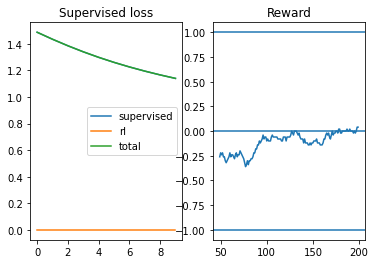


[[2.6014981 0.        2.6014981]
 [2.5230985 0.        2.5230985]
 [2.4515305 0.        2.4515305]
 [2.3872135 0.        2.3872135]
 [2.3304758 0.        2.3304758]
 [2.2813525 0.        2.2813525]
 [2.2392926 0.        2.2392926]
 [2.2033036 0.        2.2033036]
 [2.1722915 0.        2.1722915]
 [2.1452942 0.        2.1452942]]


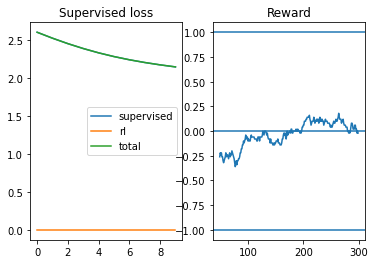


[[3.6079102 0.        3.6079102]
 [3.527133  0.        3.527133 ]
 [3.4558496 0.        3.4558496]
 [3.3916035 0.        3.3916035]
 [3.3345468 0.        3.3345468]
 [3.2852364 0.        3.2852364]
 [3.243268  0.        3.243268 ]
 [3.2073522 0.        3.2073522]
 [3.1762042 0.        3.1762042]
 [3.1489797 0.        3.1489797]]


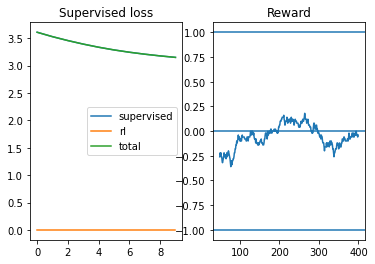


[[4.6114655 0.        4.6114655]
 [4.531898  0.        4.531898 ]
 [4.459455  0.        4.459455 ]
 [4.395443  0.        4.395443 ]
 [4.3386016 0.        4.3386016]
 [4.289066  0.        4.289066 ]
 [4.246853  0.        4.246853 ]
 [4.210894  0.        4.210894 ]
 [4.1798434 0.        4.1798434]
 [4.152675  0.        4.152675 ]]


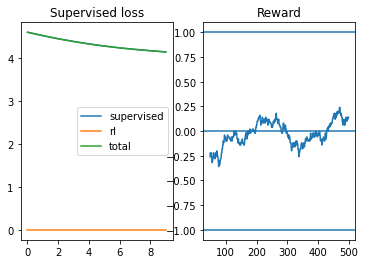


[[5.615094  0.        5.615094 ]
 [5.5361915 0.        5.5361915]
 [5.4632382 0.        5.4632382]
 [5.399046  0.        5.399046 ]
 [5.342349  0.        5.342349 ]
 [5.292804  0.        5.292804 ]
 [5.250454  0.        5.250454 ]
 [5.214439  0.        5.214439 ]
 [5.1833854 0.        5.1833854]
 [5.156206  0.        5.156206 ]]


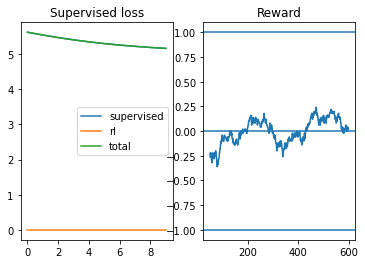


[[6.618622  0.        6.618622 ]
 [6.540741  0.        6.540741 ]
 [6.4669104 0.        6.4669104]
 [6.4028206 0.        6.4028206]
 [6.3462505 0.        6.3462505]
 [6.296568  0.        6.296568 ]
 [6.254059  0.        6.254059 ]
 [6.217992  0.        6.217992 ]
 [6.186969  0.        6.186969 ]
 [6.159835  0.        6.159835 ]]


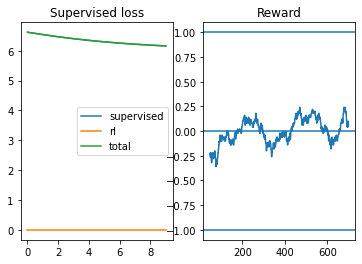


[[7.6222363 0.        7.6222363]
 [7.5448318 0.        7.5448318]
 [7.4707284 0.        7.4707284]
 [7.406319  0.        7.406319 ]
 [7.3499403 0.        7.3499403]
 [7.3002844 0.        7.3002844]
 [7.2576427 0.        7.2576427]
 [7.221491  0.        7.221491 ]
 [7.190447  0.        7.190447 ]
 [7.163357  0.        7.163357 ]]


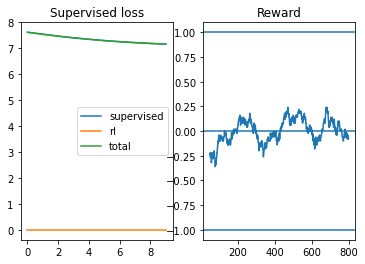


[[8.6258   0.       8.6258  ]
 [8.549218 0.       8.549218]
 [8.474384 0.       8.474384]
 [8.409961 0.       8.409961]
 [8.353728 0.       8.353728]
 [8.304012 0.       8.304012]
 [8.261224 0.       8.261224]
 [8.225008 0.       8.225008]
 [8.193983 0.       8.193983]
 [8.166925 0.       8.166925]]


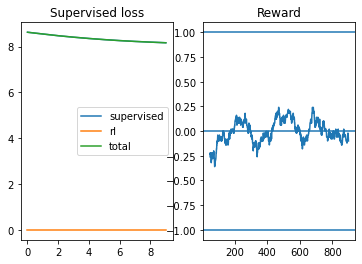


[[9.629365  0.        9.629365 ]
 [9.5533905 0.        9.5533905]
 [9.478168  0.        9.478168 ]
 [9.413513  0.        9.413513 ]
 [9.357407  0.        9.357407 ]
 [9.307774  0.        9.307774 ]
 [9.26482   0.        9.26482  ]
 [9.228465  0.        9.228465 ]
 [9.197475  0.        9.197475 ]
 [9.170503  0.        9.170503 ]]


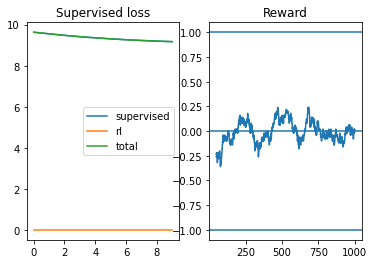


[[10.632929  0.       10.632929]
 [10.557585  0.       10.557585]
 [10.481873  0.       10.481873]
 [10.417095  0.       10.417095]
 [10.361074  0.       10.361074]
 [10.311464  0.       10.311464]
 [10.268416  0.       10.268416]
 [10.231965  0.       10.231965]
 [10.200964  0.       10.200964]
 [10.174023  0.       10.174023]]


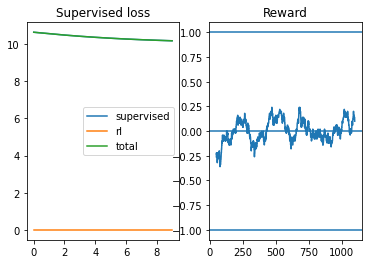

In [22]:
for _ in range(10):

    plt.figure()

    for _ in tqdm(range(100)):
        rew = U.episode()
    
    # this is one supervised learning step
    supervised_losses += fit_rl_agent_on_supervised_data(adversary_agent_model, xis, acts, epochs=10)

    plt.subplot(1, 2, 1)
    plt.title("Supervised loss")
    supervised_losses = np.array(supervised_losses)
    plt.plot(supervised_losses[:, 0], label="supervised")
    plt.plot(supervised_losses[:, 1], label="rl")
    plt.plot(supervised_losses[:, 2], label="total")
    print(supervised_losses)
    plt.legend()


    plt.subplot(1, 2, 2)
    plt.title("Reward")
    plt.plot(pd.Series(A1.reward_by_opponent[adversary_agent_model]).rolling(50).mean())
    plt.axhline(0)
    plt.axhline(1)
    plt.axhline(-1)

    plt.show()
    
    # resetting data
    adversary_agent_model.train_data = []

## now, the adversary is ready, and WE can train AGAINST it

In [23]:
m_adv_train_main = Monitor(agents=AGENTS + [A1, adversary_agent_model])

# to allow it defeat US
A1.do_train = True
adversary_agent_model.do_train = False
U = Universe(environment=env, agents=[A1, adversary_agent_model], monitor=m_adv_train_main)

In [24]:
for _ in tqdm(range(1000)):
    rew = U.episode()

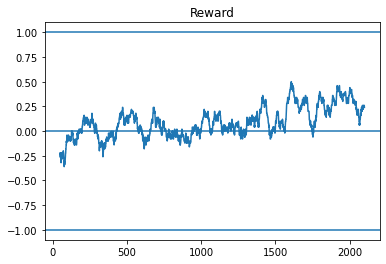

In [25]:
plt.title("Reward")
plt.plot(pd.Series(A1.reward_by_opponent[adversary_agent_model]).rolling(50).mean())
plt.axhline(0)
plt.axhline(1)
plt.axhline(-1)
plt.show()

## now we evaluate against the original opponent

In [26]:
A1.do_train = False
A2.do_train = False
U = Universe(environment=env, agents=[A1, A2], monitor=m_estimate)
for _ in tqdm(range(100)):
    rew = U.episode()

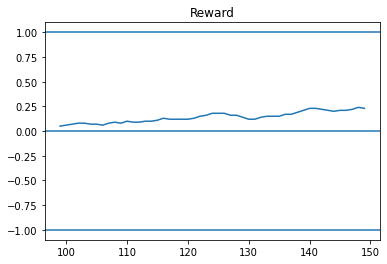

In [27]:
plt.title("Reward")
plt.plot(pd.Series(A1.reward_by_opponent[A2]).rolling(100).mean())
plt.axhline(0)
plt.axhline(1)
plt.axhline(-1)
plt.show()

Success! We have trained an agent in simulation, and then defended against it!

Effect size is small -> try GAIL -- there are CHAI/OpenAI implementations.

With supervised, works better than with supervised + rl?
RL goes into a specific direction?

# Training with alternating + and - reward (collaboration vs competition)
1. An adversary is trained to be cooperative
2. An adversary is then switched to being competitive

In [8]:
A1 = RPCAgent(noise_dim=env.noise_dim, identity=0)
A2 = RPCAgent(noise_dim=env.noise_dim, identity=1)
AGENTS = [A1, A2]
true_opponent = AGENTS.index(A2)
print(true_opponent)

A1.do_train = False
A2.do_train = True

# to track the performance
m = Monitor(agents=AGENTS)

1


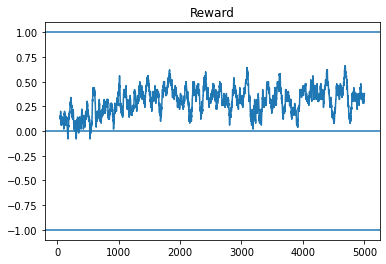

In [9]:
U = Universe(environment=env, agents=[A1, A2], monitor=m, invert_reward_2=True)
for _ in tqdm(range(5000)):
    rew = U.episode()
    
plt.title("Reward")
plt.plot(pd.Series(A1.reward_by_opponent[A2]).rolling(50).mean())
plt.axhline(0)
plt.axhline(1)
plt.axhline(-1)
plt.show()

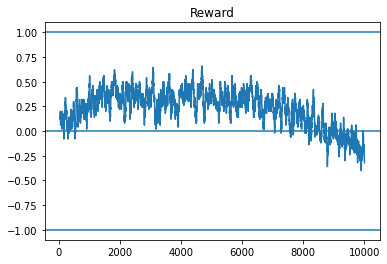

In [10]:
U = Universe(environment=env, agents=[A1, A2], monitor=m, invert_reward_2=False)
for _ in tqdm(range(5000)):
    rew = U.episode()
    
plt.title("Reward")
plt.plot(pd.Series(A1.reward_by_opponent[A2]).rolling(50).mean())
plt.axhline(0)
plt.axhline(1)
plt.axhline(-1)
plt.show()

Try with previous actions instead of random noise?